# 5. How to Log and Visualize Simulations

Here we explain how to take a log of simulation results and how to visualize it. 

In [1]:
%matplotlib inline
import math
from ecell4 import *

## 5.1. Logging Simulations with Observers

E-Cell4 provides special classes for logging, named `Observer`. `Observer` class is given when you call the `run` function of `Simulator`.

In [2]:
def create_simulator(f=gillespie.GillespieFactory()):
    m = NetworkModel()
    A, B, C = Species('A', '0.005', '1'), Species('B', '0.005', '1'), Species('C', '0.005', '1')
    m.add_reaction_rule(create_binding_reaction_rule(A, B, C, 0.01))
    m.add_reaction_rule(create_unbinding_reaction_rule(C, A, B, 0.3))
    w = f.create_world()
    w.bind_to(m)
    w.add_molecules(C, 60)
    sim = f.create_simulator(w)
    sim.initialize()
    return sim

One of most popular `Observer` is `FixedIntervalNumberObserver`, which logs the number of molecules with the given time interval. `FixedIntervalNumberObserver` requires an interval and a list of serials of `Species` for logging.

In [3]:
obs1 = FixedIntervalNumberObserver(0.1, ['A', 'B', 'C'])
sim = create_simulator()
sim.run(1.0, obs1)

`data` function of `FixedIntervalNumberObserver` returns the data logged.

In [4]:
print(obs1.data())

[[0.0, 0.0, 0.0, 60.0], [0.1, 1.0, 1.0, 59.0], [0.2, 2.0, 2.0, 58.0], [0.30000000000000004, 3.0, 3.0, 57.0], [0.4, 5.0, 5.0, 55.0], [0.5, 7.0, 7.0, 53.0], [0.6000000000000001, 8.0, 8.0, 52.0], [0.7000000000000001, 8.0, 8.0, 52.0], [0.8, 8.0, 8.0, 52.0], [0.9, 10.0, 10.0, 50.0], [1.0, 10.0, 10.0, 50.0]]


`NumberObserver` logs the number of molecules after every steps when a reaction occurs. This observer is useful to log all reactions, but not available for `ode`.

In [5]:
obs1 = NumberObserver(['A', 'B', 'C'])
sim = create_simulator()
sim.run(1.0, obs1)
print(obs1.data())

[[0.0, 0.0, 0.0, 60.0], [0.05665124100229075, 1.0, 1.0, 59.0], [0.22796942952742336, 2.0, 2.0, 58.0], [0.311954788143896, 3.0, 3.0, 57.0], [0.3324446848132687, 4.0, 4.0, 56.0], [0.36428046891348764, 5.0, 5.0, 55.0], [0.438063580958232, 6.0, 6.0, 54.0], [0.4747080468854431, 7.0, 7.0, 53.0], [0.48010605960234853, 8.0, 8.0, 52.0], [0.6360066043869752, 9.0, 9.0, 51.0], [0.6617167514080139, 10.0, 10.0, 50.0], [0.7070804236086033, 11.0, 11.0, 49.0], [0.7680565908982273, 12.0, 12.0, 48.0], [0.8561821536466694, 13.0, 13.0, 47.0], [1.0, 13.0, 13.0, 47.0]]


`run` function accepts multile `Observer`s at once.

In [6]:
obs1 = NumberObserver(['C'])
obs2 = FixedIntervalNumberObserver(0.1, ['A', 'B'])
sim = create_simulator()
sim.run(1.0, [obs1, obs2])
print(obs1.data())
print(obs2.data())

[[0.0, 60.0], [0.05665124100229075, 59.0], [0.18270494942243265, 58.0], [0.23095956985892852, 57.0], [0.33530147502935526, 56.0], [0.3405180686867892, 55.0], [0.4247277891647125, 54.0], [0.46855742414112744, 53.0], [0.5851683290991655, 52.0], [0.8296633504301292, 51.0], [0.8392970570664094, 50.0], [1.0, 50.0]]
[[0.0, 0.0, 0.0], [0.1, 1.0, 1.0], [0.2, 2.0, 2.0], [0.30000000000000004, 3.0, 3.0], [0.4, 5.0, 5.0], [0.5, 7.0, 7.0], [0.6000000000000001, 8.0, 8.0], [0.7000000000000001, 8.0, 8.0], [0.8, 8.0, 8.0], [0.9, 10.0, 10.0], [1.0, 10.0, 10.0]]


`FixedIntervalHDF5Observedr` logs the whole data in a `World` to an output file with the fixed interval. Its second argument is a prefix for output filenames.

In [7]:
obs1 = FixedIntervalHDF5Observer(0.2, 'data/test%02d.h5')
sim = create_simulator()
sim.run(1.0, obs1)

In [8]:
w = load_world('data/test05.h5')
print(w.t(), w.num_molecules(Species('C')))

(1.0, 49)


For particle simulations, E-Cell4 also provides `Observer` to trace a trajectory of a molecule, named `FixedIntervalTrajectoryObserver`. When no `ParticleID` is specified, it logs all the trajectories.

In [9]:
sim = create_simulator(spatiocyte.SpatiocyteFactory(0.005))
obs1 = FixedIntervalTrajectoryObserver(0.01)
sim.run(0.1, obs1)

In [10]:
print([tuple(pos) for pos in obs1.data()[0]])

[(0.008164965809277261, 0.2107328482542134, 0.8250000000000001), (0.16329931618554522, 0.268467875173176, 0.705), (0.05715476066494083, 0.2800148805569685, 0.665), (-0.03265986323710901, 0.4676537180435969, 0.55), (-0.15513435037626788, 0.5311622476544557, 0.74), (0.00816496580927728, 0.6091045339950553, 0.985), (-0.13063945294843615, 0.7188010851410841, 1.055), (-0.13063945294843615, 0.8054036255195279, 1.065), (-0.10614455552060431, 0.9122134253196088, 1.02), (0.155134350376268, 0.7216878364870323, 1.12), (0.187794213613377, 0.6350852961085884, 0.9300000000000002)]


## 5.2. Visualization of Data Logged

In this section, we explain the visualization tools for data logged by `Observer`.

Firstly, for time course data, `plot_number_observer` plots the data provided by `NumberObserver`s.

In [11]:
obs1 = NumberObserver(['C'])
obs2 = FixedIntervalNumberObserver(0.1, ['A', 'B'])
sim = create_simulator()
sim.run(10.0, [obs1, obs2])

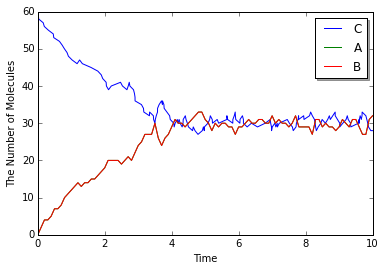

In [12]:
viz.plot_number_observer(obs1, obs2)

You can set the style for plotting, and even add an arbitrary function to plot.

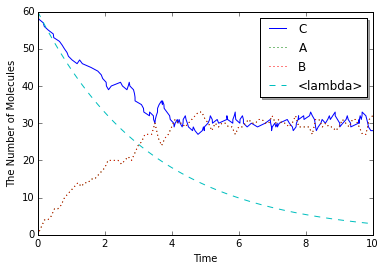

In [13]:
viz.plot_number_observer(obs1, '-', obs2, ':', lambda t: 60 * math.exp(-0.3 * t), '--')

Plotting in the phase plane is also available by specifing the x-axis and y-axis.

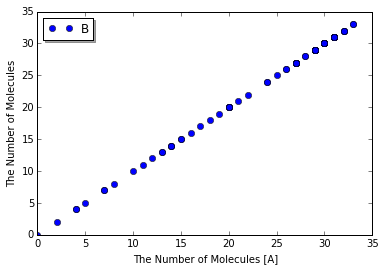

In [14]:
viz.plot_number_observer(obs2, 'o', x='A', y='B')

For spatial simulations, to visualize the state of `World`, `viz.plot_world` is available. This function plots the points of particles in three-dimensional volume in the interactive way. You can save the image by clicking a right button on the drawing region.

In [15]:
sim = create_simulator(spatiocyte.SpatiocyteFactory(0.005))
viz.plot_world(sim.world())

You can also make a movie from a series of HDF5 files, given as a `FixedIntervalHDF5Observer`. NOTE: `viz.plot_movie_with_matplotlib` requires an extra library, `ffmpeg`.

In [16]:
sim = create_simulator(spatiocyte.SpatiocyteFactory(0.005))
obs1 = FixedIntervalHDF5Observer(0.02, 'data/test%02d.h5')
sim.run(1.0, obs1)
viz.plot_movie_with_matplotlib(obs1)

Start generating species_list ...
Start preparing mplot3d ...
Start making animation ...
Start generating a movie ...


Finally, corresponding to `FixedIntervalTrajectoryObserver`, `viz.plot_trajectory` provides a visualization of particle trajectories.

In [17]:
sim = create_simulator(spatiocyte.SpatiocyteFactory(0.005))
obs1 = FixedIntervalTrajectoryObserver(1e-3)
sim.run(1, obs1)
viz.plot_trajectory(obs1)